# Fragility Analyses With Row/Column Perturbations

Since the linear operator estimated from the windowed data matrices are not symmetric, then the corresponding row and column perturbations are different. Although there lacks some theory to describe how different they are depending on matrix properties, we can empirically investigate the differences in the context of EZ localization.

Here, we:

1. load and visualize the column/row perturbed fragility heaatmaps
2. load and visualize their combinations (mean, ratio)

In [1]:
import numpy as np
import pandas as pd
import mne
import os
import json
import os.path as op
from pathlib import Path
import collections
from natsort import natsorted

from sklearn.datasets import make_spd_matrix
from mne.io import RawArray
from mne import create_info
from mne_bids import BIDSPath, get_entity_vals, read_raw_bids
import mne
mne.utils.use_log_level('error')
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl

import dabest

from eztrack.io.base import _add_desc_to_bids_fname, concatenate_derivs
from eztrack.io import read_derivative_npy, DerivativeArray, create_deriv_info
from eztrack.fragility import (lds_raw_fragility, DiscreteLinearSystem, 
                               SystemIDModel, StructuredPerturbationModel)
from eztrack.viz import _load_turbo, generate_heatmap
from eztrack.posthoc.hypo import compute_null

_load_turbo()

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_resected_chs(subject, root):
    bids_path = BIDSPath(subject=subject, root=root,
                         suffix='channels', extension='.tsv')
    ch_fpaths = bids_path.match()

    # read in sidecar channels.tsv
    channels_pd = pd.read_csv(ch_fpaths[0], sep='\t')
    description_chs = pd.Series(channels_pd.description.values, index=channels_pd.name).to_dict()
    resected_chs = [ch for ch, description in description_chs.items() if description == 'resected']
    return resected_chs

# Configure Paths and BIDS related metadata

In [3]:
# load in originally ran npy data
root = Path('/Users/adam2392/OneDrive - Johns Hopkins/sickkids/')
root = Path('/Users/adam2392/Dropbox/epilepsy_bids/')
deriv_root = root / 'derivatives'
reference = 'monopolar'
sampling_res = '1000Hz'  # 'originalsampling'
deriv_chain = Path(sampling_res) / 'radius1.25' / 'fragility' / reference
deriv_path = deriv_root / deriv_chain

figures_path = deriv_root / 'figures'

sessions = ['extraoperative', 'preresection', 
            'intraresection', 'postresection']
desc = 'perturbmatrix'
rowdesc = 'rowperturbmatrix'

In [4]:
subject = 'E1'
session = 'extraoperative'
task = 'ictal'
acquisition = 'ecog'
run = '01'
datatype = 'ieeg'
extension = '.vhdr'

subject = 'pt1'
session = 'presurgery'
acquisition = 'ecog'
run = '01'

In [5]:
subjects = get_entity_vals(deriv_path, 'subject')
ignore_subjects = [sub for sub in subjects if sub != subject]

sessions = get_entity_vals(deriv_path, 'session', ignore_subjects=ignore_subjects)
ignore_sessions = [ses for ses in sessions if ses != session]

tasks = get_entity_vals(deriv_path, 'task', 
                        ignore_subjects=ignore_subjects,
                        ignore_sessions=ignore_sessions
                       )

print(f'These are the tasks for {subject} {session}: {tasks}')
task = tasks[-1]

print(task)

These are the tasks for pt1 presurgery: []


IndexError: list index out of range

In [8]:
bids_path = BIDSPath(subject=subject, session=session,task=task,
                    acquisition=acquisition, run=run, suffix=datatype,
                    datatype=datatype, extension=extension,
                    root=root)
print(bids_path)

/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/ses-presurgery/ieeg/sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01_ieeg.vhdr


In [13]:
deriv_fname = _add_desc_to_bids_fname(bids_path.basename, description=desc)
print(deriv_fname)

sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.vhdr


In [14]:
deriv_fpath = deriv_root / deriv_chain / f'sub-{subject}' / deriv_fname
print(deriv_fpath)
print(deriv_fpath.exists())

/Users/adam2392/OneDrive - Johns Hopkins/sickkids/derivatives/1000Hz/radius1.25/fragility/monopolar/sub-E1/sub-E1_ses-extraoperative_task-interictalawake_acq-ecog_run-01_desc-perturbmatrix_ieeg.vhdr
False


# Load Data

In [13]:
verbose = False
raw = read_raw_bids(bids_path, verbose=verbose)

pick_dict = dict(eeg=True, ecog=True, seeg=True)
raw = raw.pick_types(**pick_dict)
raw = raw.drop_channels(raw.info['bads'])
raw.load_data()
raw = raw.filter(l_freq=1, h_freq=300, verbose=verbose)
raw = raw.notch_filter(freqs=np.arange(60, 300, 60), method='fir', verbose=verbose)

/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any electrodes.tsv associated with sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*electrodes.tsv"
  warn(msg)
/Users/adam2392/Documents/sickkids/.venv/lib/python3.8/site-packages/mne_bids/path.py:1065: RuntimeWarning: Did not find any coordsystem.json associated with sub-pt1_ses-presurgery_task-ictal_acq-ecog_run-01.

The search_str was "/Users/adam2392/Dropbox/epilepsy_bids/sub-pt1/**/sub-pt1_ses-presurgery*coordsystem.json"
  warn(msg)


In [22]:
raw = raw.crop(tmin=0, tmax=20)
pert_deriv = lds_raw_fragility(raw, method_to_use='pinv', radius=2.0, l2penalty=1e-7)




Fragility Heatmap:   0%|          | 0/159 [00:00<?, ?eeg window/s]

Using pinv least squares with l2penalty 1e-07.
Data matrix shape input: (84, 20001). Estimate state array with SystemIDModel(fb=True, fit_intercept=True, l2penalty=1e-07, normalize=True) and compute perturbation with Structured Perturbation Model | radius=2.0, perturb_type=C.





Fragility Heatmap:   5%|▌         | 8/159 [00:00<00:02, 71.91eeg window/s]


Fragility Heatmap:  10%|█         | 16/159 [00:05<00:54,  2.61eeg window/s]


Fragility Heatmap:  15%|█▌        | 24/159 [00:05<00:30,  4.43eeg window/s]

ValueError: The largest eigenvalue of A has absolute value of 2.166560356588316, so perturbation to 2.0 is ill-defined.


Fragility Heatmap:  15%|█▌        | 24/159 [00:24<00:31,  4.35eeg window/s]


Fragility Heatmap:  15%|█▌        | 24/159 [00:21<00:30,  4.43eeg window/s]

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

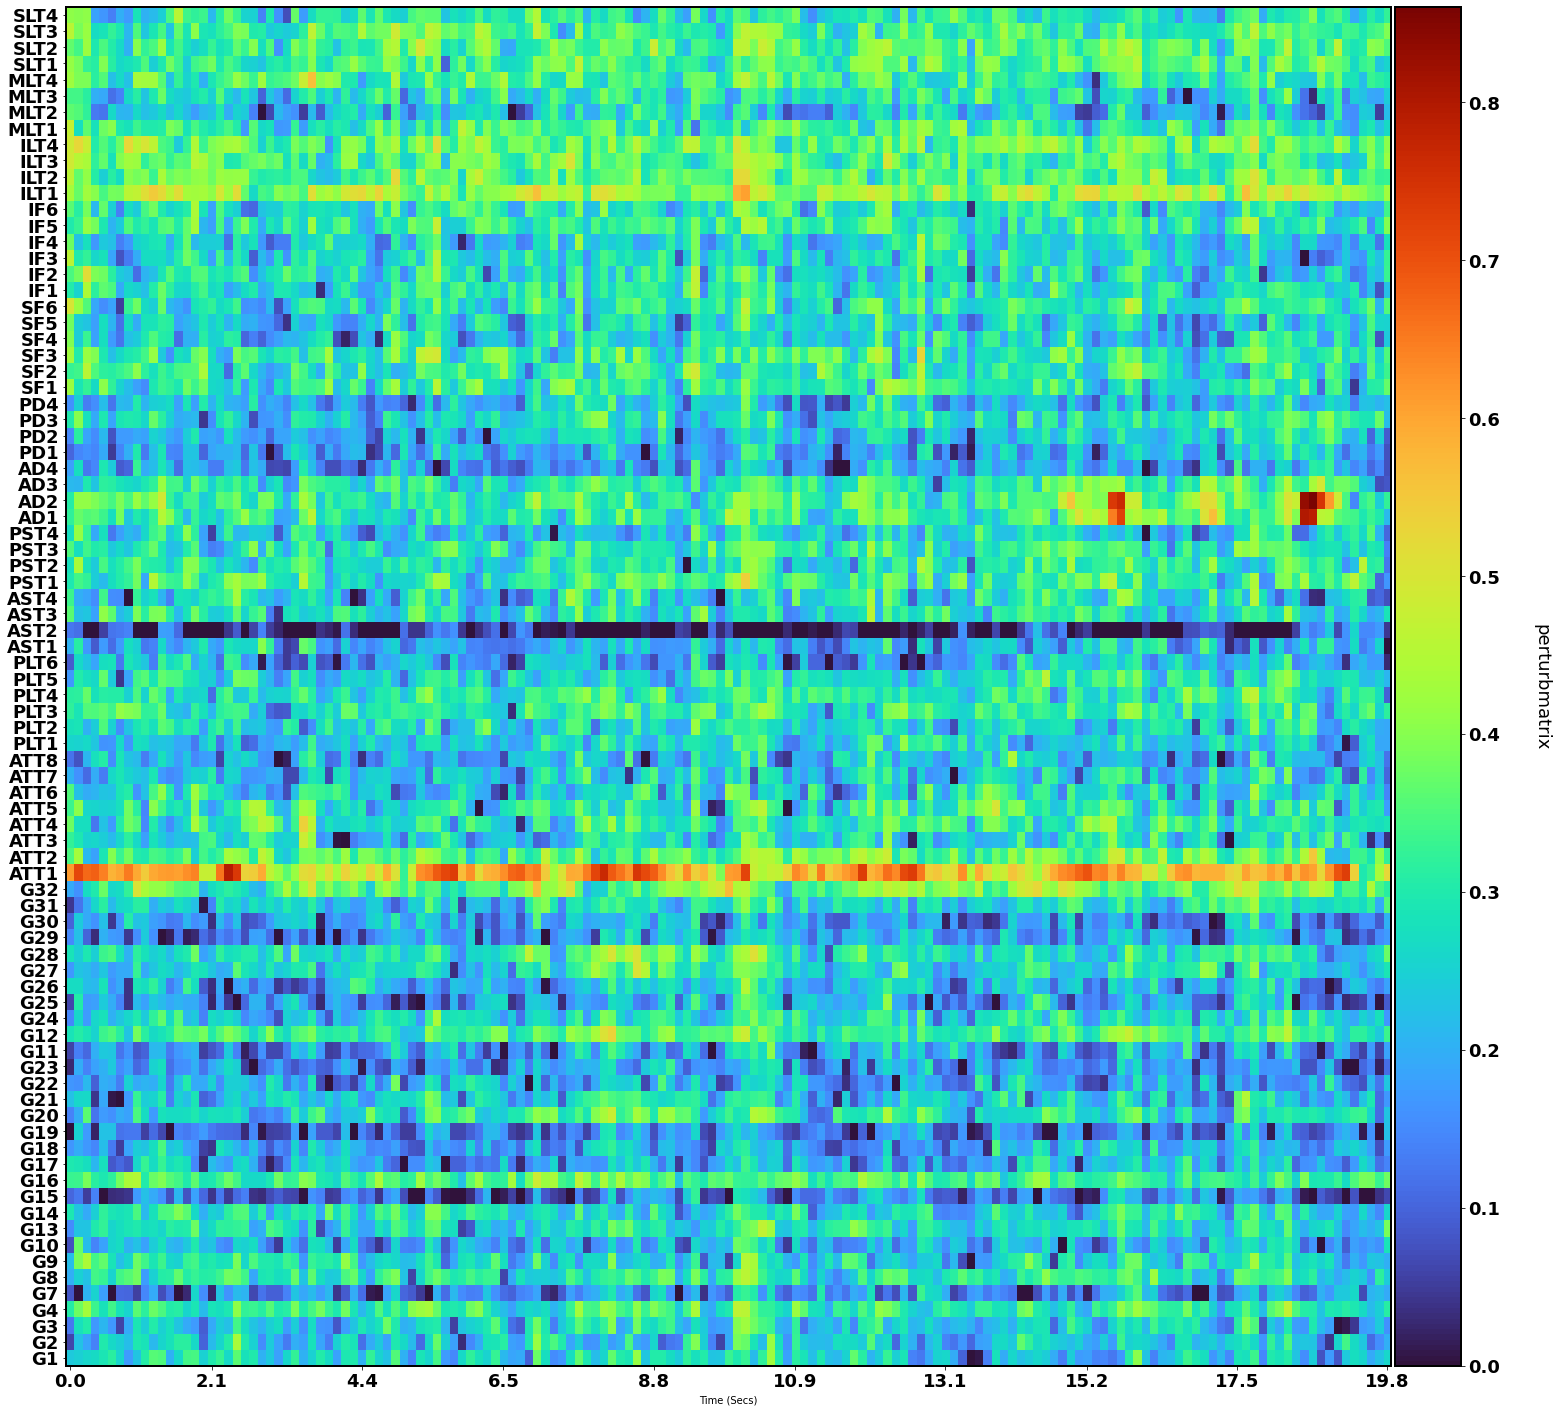

In [19]:
pert_deriv.normalize()
pert_deriv.plot_heatmap()

/Users/adam2392/Documents/eztrack/eztrack/viz/plot_fragility_heatmap.py:307: MatplotlibDeprecationWarning: You are modifying the state of a globally registered colormap. In future versions, you will not be able to modify a registered colormap in-place. To remove this warning, you can make a copy of the colormap first. cmap = copy.copy(mpl.cm.get_cmap("turbo"))
  my_cmap.set_bad(color="w")


(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

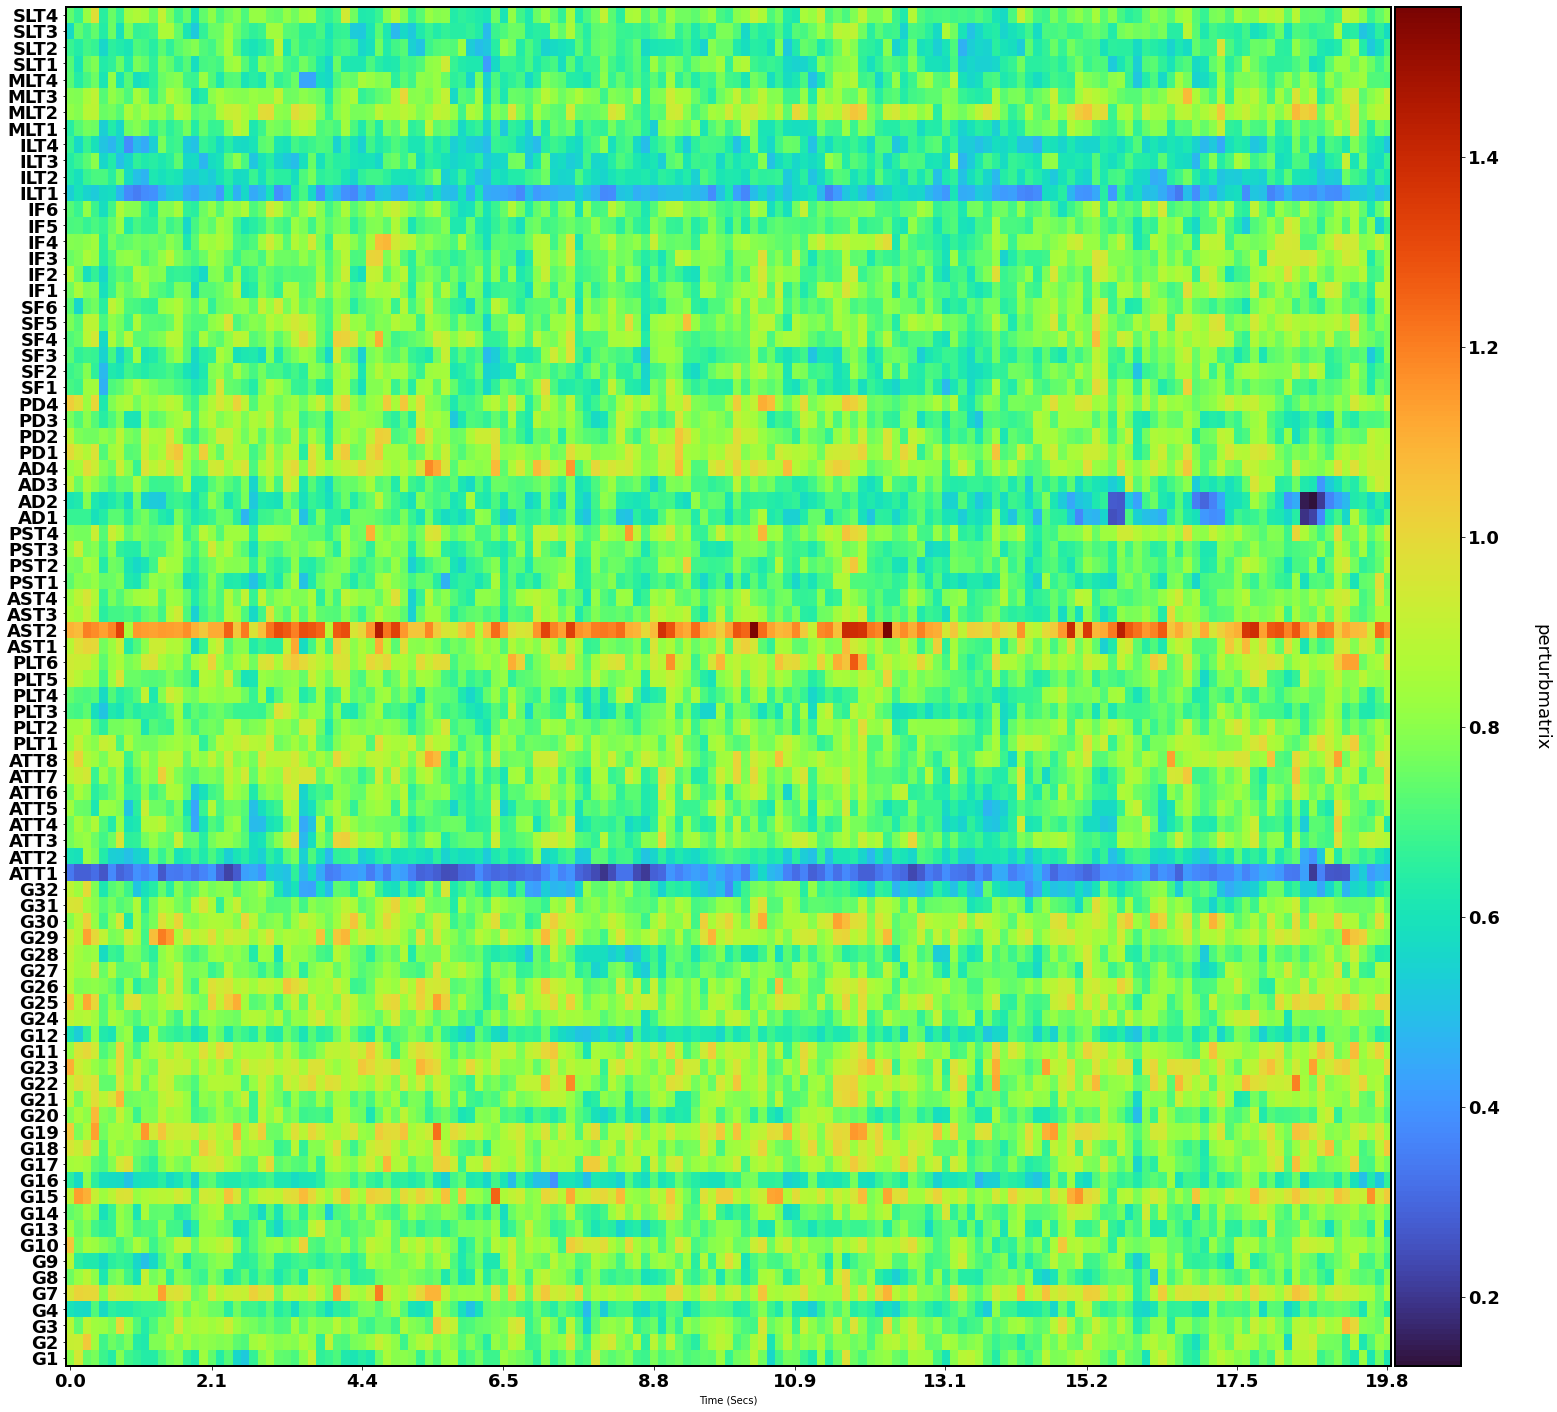

In [36]:
pert_deriv.plot_heatmap()

(<Figure size 1800x1800 with 2 Axes>, <AxesSubplot:xlabel='Time (Secs)'>)

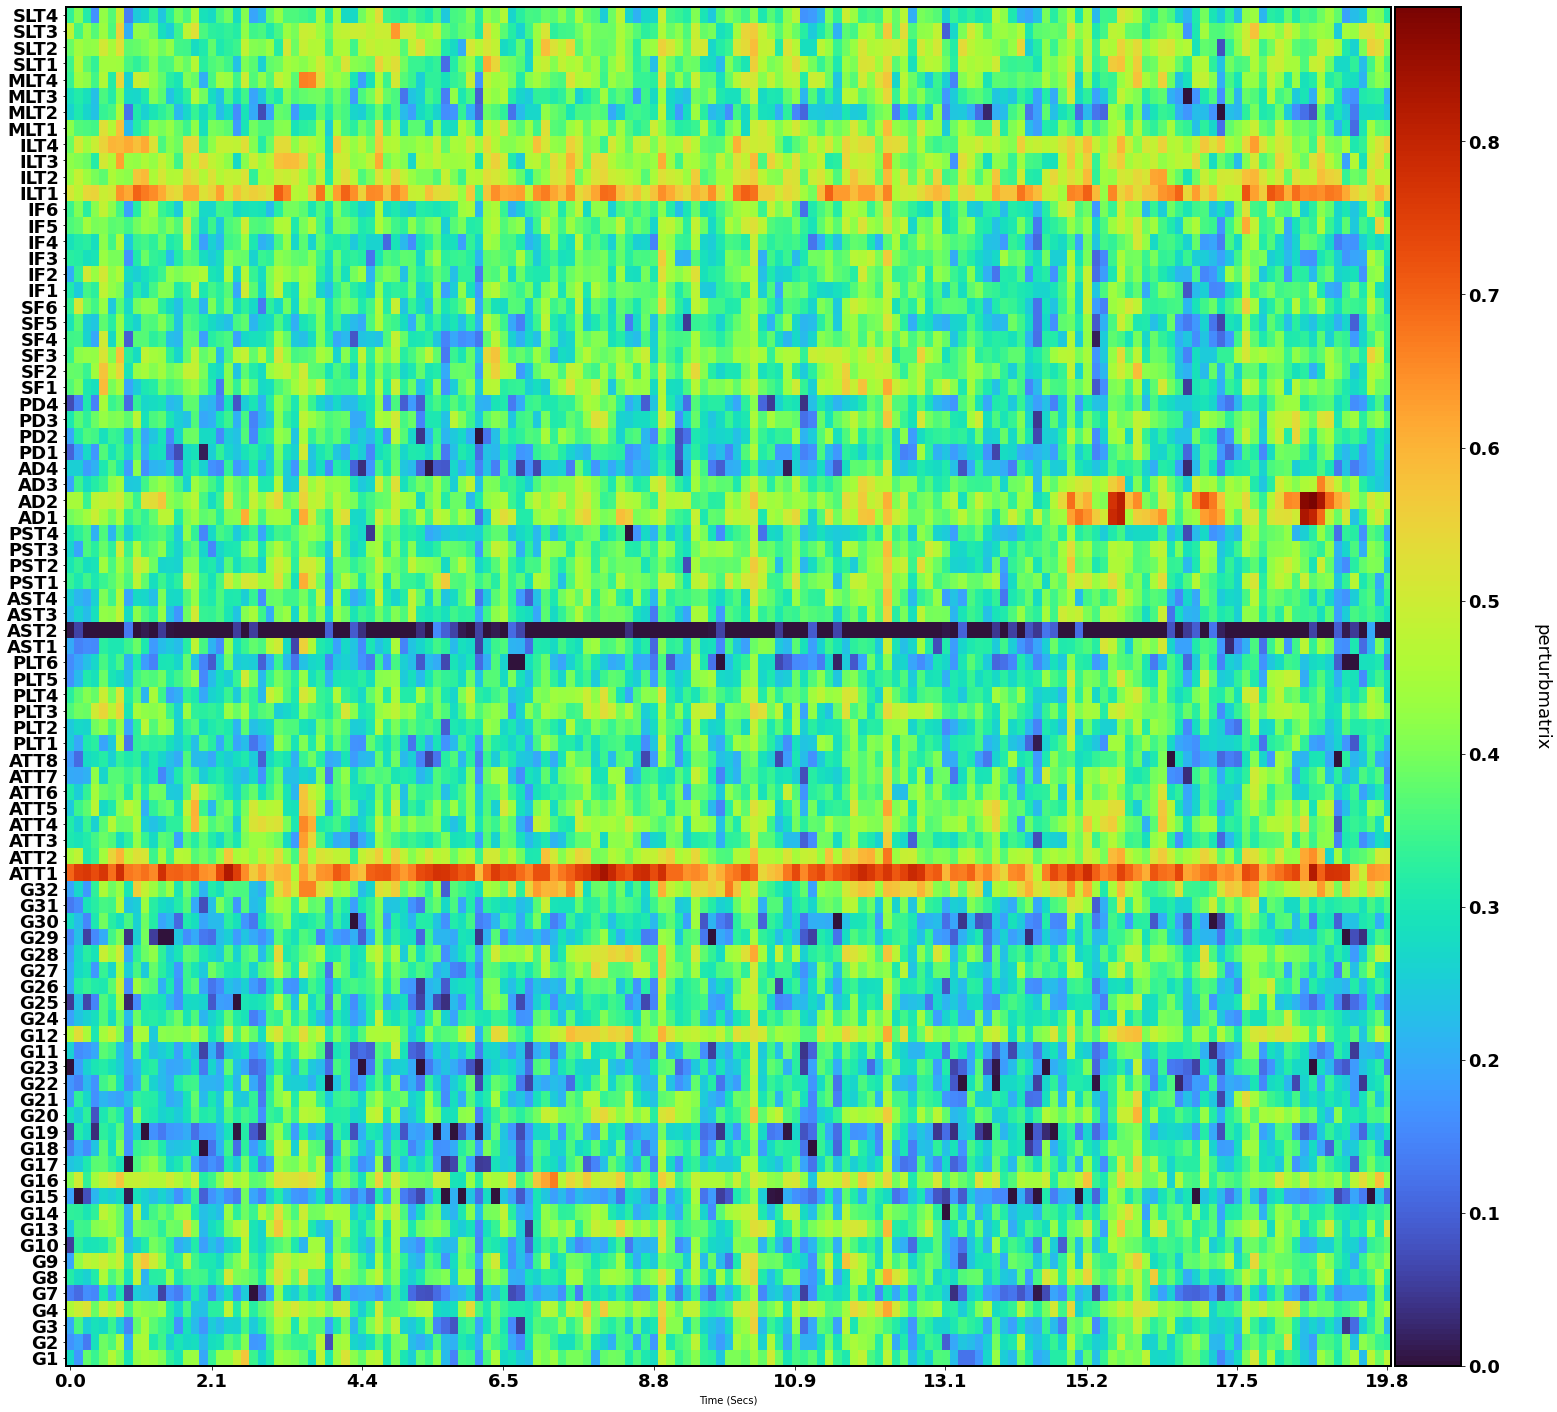

In [37]:
pert_deriv.normalize()
pert_deriv.plot_heatmap()